In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers

import seaborn as sns
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import multipletests

Using TensorFlow backend.


In [2]:
gene_correlation = 0.8
latent_dim = 5
epochs = 50
batch_size = 50
learning_rate = 0.001

activation = 'sigmoid'

In [3]:
x = pd.read_table('./Data/Ov_Cancer_mRNA.txt', index_col=0)
starting_genes = np.load('./Data/Lists/gene_list_'+str(gene_correlation)+'.npy')
x = x.iloc[starting_genes].T 
x = (x - np.min(x))/(np.max(x) - np.min(x))

In [4]:
train_percent = 0.6
x_train = x.head(int((train_percent)*len(x)))
x_test = x.tail(len(x)-int((train_percent)*len(x)))
original_dim = x.shape[1]
print(x_train.head(5)) #patients go down the left, genes run across

                  ABL1    ALKBH2    ALKBH3     APEX1     APEX2      APLF  \
TCGA.61.1917  0.433569  0.784358  0.660404  0.619420  0.490660  0.684342   
TCGA.24.2038  0.619225  0.746032  0.653653  0.380328  0.303752  0.565547   
TCGA.09.2048  0.278142  0.976105  0.658688  0.547734  0.479630  0.542460   
TCGA.04.1362  0.873346  0.362670  0.738334  0.257347  0.497800  0.486140   
TCGA.25.2391  0.373909  0.346528  0.559372  0.352229  0.671173  0.498429   

                  APTX     ATAD5       ATM     ATRIP    ...         XAB2  \
TCGA.61.1917  0.582068  0.593892  0.399202  0.000000    ...     0.340096   
TCGA.24.2038  0.339484  0.313406  0.485077  0.502339    ...     0.424211   
TCGA.09.2048  0.783500  0.616759  0.612194  0.287584    ...     0.376187   
TCGA.04.1362  0.305714  0.596782  0.492696  0.332279    ...     0.316592   
TCGA.25.2391  0.632493  0.472561  0.455709  0.441141    ...     0.143704   

                   XPA       XPC     XRCC1     XRCC2     XRCC3     XRCC4  \
TCGA.61.19

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=1)
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z

In [6]:
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [7]:
mRNA_input = Input(shape=(original_dim, ))

z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(mRNA_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation(activation)(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(mRNA_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation(activation)(z_log_var_dense_batchnorm)

z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

In [8]:
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
rnaseq_reconstruct = decoder_to_reconstruct(z)

In [9]:
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([mRNA_input, rnaseq_reconstruct])
vae = Model(mRNA_input, vae_layer)
vae.compile(optimizer=adam, loss=None)

In [10]:
hist = vae.fit(np.array(x_train),
               shuffle=True,
               epochs=epochs,
               verbose=0,
               batch_size=batch_size,
               validation_data=(np.array(x_test), None),
               callbacks=[])
print("Training complete")

Training complete


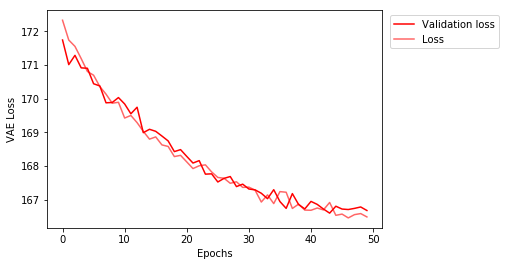

In [11]:
plt.subplots()
plt.plot(hist.history["val_loss"], color='r', label='Validation loss')
plt.plot(hist.history["loss"], color='r',alpha = 0.6, label='Loss')
plt.xlabel('Epochs')
plt.ylabel(r'VAE Loss')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2)

In [12]:
encoder = Model(mRNA_input, z_mean_encoded)
z = encoder.predict_on_batch(x_test)
z = pd.DataFrame(z, index=x_test.index)
z.columns = z.columns + 1

In [13]:
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

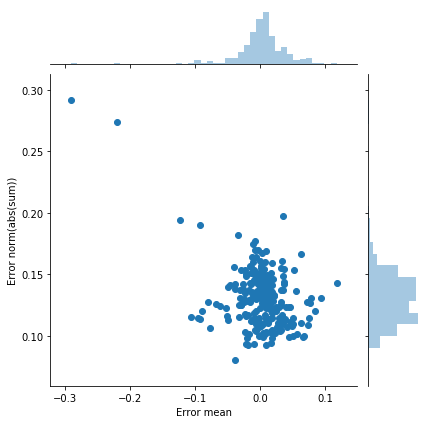

In [14]:
x_reconstruct = decoder.predict(np.array(z))
x_reconstruct = pd.DataFrame(x_reconstruct, index=x_test.index,
                                        columns=x_test.columns)

reconstruction_fidelity = x_test - x_reconstruct
gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(x_test.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['Error mean', 'Error norm(abs(sum))']).T
gene_summary.sort_values(by='Error norm(abs(sum))', ascending=False).head()

# Mean of gene reconstruction vs. absolute reconstructed difference per sample
sns.jointplot('Error mean', 'Error norm(abs(sum))', data=gene_summary, stat_func=None);

In [15]:
print('Truth:')
print(x_test.head(5))
print('Reconstructed truth:')
print(x_reconstruct.head(5))

Truth:
                  ABL1    ALKBH2    ALKBH3     APEX1     APEX2      APLF  \
TCGA.OY.A56Q  0.768175  0.399319  0.135295  0.351062  0.293825  0.466606   
TCGA.09.0369  0.723874  0.838585  0.702325  0.479283  0.485294  0.610629   
TCGA.24.1604  0.337172  0.446858  0.606943  0.419579  0.417953  0.593616   
TCGA.OY.A56P  0.795992  0.459675  0.409369  0.152685  0.319990  0.665252   
TCGA.25.1321  0.514001  0.286497  0.660963  0.747176  0.322736  0.710387   

                  APTX     ATAD5       ATM     ATRIP    ...         XAB2  \
TCGA.OY.A56Q  0.776648  0.588428  0.578629  0.510254    ...     0.267477   
TCGA.09.0369  0.454361  0.579622  0.280786  0.655343    ...     0.460457   
TCGA.24.1604  0.304356  0.428151  0.674499  0.371638    ...     0.475391   
TCGA.OY.A56P  0.579958  0.860630  1.000000  0.578148    ...     0.929957   
TCGA.25.1321  0.222233  0.610743  0.570499  0.114298    ...     0.315718   

                   XPA       XPC     XRCC1     XRCC2     XRCC3     XRCC4  \
TCG

In [16]:
resistant_patients = np.load('./Data/Lists/resistant_patients.npy')
present_resistant_patients = np.intersect1d(resistant_patients,x_test.index.values)
sensitive_patients = np.load('./Data/Lists/sensitive_patients.npy')
present_sensitive_patients = np.intersect1d(sensitive_patients,x_test.index.values)

In [17]:
p_values = np.empty((latent_dim))
for i in range(latent_dim):
    latent_var_list = z.iloc[:,i]
    r = latent_var_list.reindex(present_resistant_patients).values
    s = latent_var_list.reindex(present_sensitive_patients).values
    p_values[i] = ks_2samp(r,s)[1]
adjusted_p_values = multipletests(p_values, method='fdr_bh', alpha=0.25)[1]
significant_list = (adjusted_p_values < 0.25)
significant_LVs = np.array([p_values,np.arange(latent_dim)]).T[np.array([p_values,np.arange(latent_dim)])[0].argsort()].T[1][:sum(significant_list)].astype(int)

Number of significant latent variables found: 1
The latent space performance (LSP) was caluclated to be: 6.398
The best latent variable (LV 1) seperates platinum resistant patients from sensitive patients with a p value of 0.04080


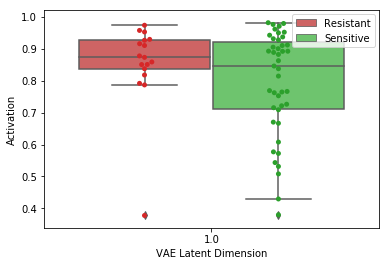

In [23]:
if len(significant_LVs) == 0:
    print("None of the latent variables were found to be significant, please try again.")

else:
    plotdata = []
    for i in range(len(significant_LVs)):
        plotdata = np.append(plotdata,z.iloc[:,significant_LVs[i]].reindex(present_resistant_patients).values)
        plotdata = np.append(plotdata,z.iloc[:,significant_LVs[i]].reindex(present_sensitive_patients).values)
    plotvariables = []
    for i in range(len(significant_LVs)):
        plotvariables = np.append(plotvariables,[int(significant_LVs[i]+1)]*len(z.iloc[:,significant_LVs[i]].reindex(present_resistant_patients).values))
        plotvariables = np.append(plotvariables,[int(significant_LVs[i]+1)]*len(z.iloc[:,significant_LVs[i]].reindex(present_sensitive_patients).values))
    plotlabels = []
    for i in range(len(significant_LVs)):
        plotlabels = np.append(plotlabels,['Resistant']*len(z.iloc[:,significant_LVs[i]].reindex(present_resistant_patients).values))
        plotlabels = np.append(plotlabels,['Sensitive']*len(z.iloc[:,significant_LVs[i]].reindex(present_sensitive_patients).values))
    
    df = pd.DataFrame([plotdata,plotvariables,plotlabels]).T
    df.columns=['Activation','VAE Latent Dimension','Classification']
    df['Activation']=df['Activation'].astype(float)
    
    latent_variable_figure = plt.subplots()
    ax = sns.boxplot(x='VAE Latent Dimension', y='Activation', hue='Classification', data = df, palette=sns.color_palette(["#df5353", "#5fd35f"]))
    ax = sns.swarmplot(x='VAE Latent Dimension', y='Activation', hue='Classification', dodge=True, data = df, palette=sns.color_palette(["#d62728", "#2ca02c"]))
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:2], labels[0:2], loc=1, borderaxespad=0.4)
    
    LSP = -2*np.sum(np.log(np.delete(p_values,np.where(adjusted_p_values>0.25))))
    best_p = np.min(p_values)


    print('Number of significant latent variables found: %g' %(len(significant_LVs)) )
    print('The latent space performance (LSP) was caluclated to be: %.3f' %LSP)
    print('The best latent variable (LV %g) seperates platinum resistant patients from sensitive patients with a p value of %.5f' %(np.argmin(p_values)+1,np.min(p_values)))        